In [1]:
 pip install prince --upgrade

Requirement already up-to-date: prince in c:\users\user\anaconda3\lib\site-packages (0.7.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,TruncatedSVD
import prince

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LinearRegression
import itertools
from sklearn import linear_model
from sklearn import metrics

#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

# data preprocessing
from imblearn.over_sampling import SMOTE

In [3]:
dataset = pd.read_excel("BD Kc colorectal_stage ESI.xlsx")
df = dataset.copy()
df.shape

(347, 189)

In [4]:
na = ["?","à compléter", 'A compléter', 'pas de n°tel','à compléter']
for col in df.columns:
    for i in range(df.shape[0]):
        if df[col][i] in na:
            df[col][i] = np.nan

<ipython-input-4-4fcac8949bd2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = np.nan


In [5]:
L = ['date_chir', 'D dernière onsultation', 'D contact tél', 
       'Decès date', 'statut_prog', 'Date recidive', 'Evolution recid',
       'remarques','Unnamed: 188']
for col in L:
    del df[col]
    

### Suppression des lignes contenant Morbidité NaN.

In [6]:
indexNames = df[df['Morbidité'].isna()].index
df.drop(indexNames , inplace=True)
df['Morbidité'].isnull().sum()

0

In [7]:
df.reset_index(drop = True, inplace = True)

### Suppression des features qui ne sont pas nécessaires ( avec accord)

In [8]:
L = ['signif Incid Perop','signif CP', 'FistJPostOP',  'signif autres.1',
     'PéritoJPostop', 'signif autres Manifcliniq ', 'signif autres','SténoJPostOP',
    'FRVJPostOP','CStomiJPostOP', 'CHémorJPostOP', 'CUrinairJPostOP' ,   'CUrinairTrait',
     'DélaisPostRCCH','DuréeSéjPostOP','DuréeSéjRéa' ,'DécJPostOP','CauseDécès']
for col in L:
    del df[col]

In [9]:
df.shape

(338, 162)

In [10]:
# Remplacer les valeurs manquantes par NaN.

li_8 = ["atcd chir","Localisation","TDMSiège", "CmplcatParié", "Cplct Générl"]
li_6_8 = ["Type histologique"]


for col in li_8:
    df.loc[df[col] == 8, col] = np.nan

df.loc[df["Décès"] == 9, "Décès"] = np.nan
df.loc[df["trouble transi"] == 2, "trouble transi"] = np.nan
df.loc[df["Type histologique"] == 6 , "Type histologique"] = np.nan
df.loc[df["Type histologique"] == 8, "Type histologique"] = np.nan
df.loc[df["ACE"] == 'inf 0,50', "ACE"] = 0.5


### Remplissage des valeurs manquantes ( pour les complications )

In [11]:
L = ['FistEvolution', 'PéritoEvolution', 'SténoEvoluti','FRVEvolution', 'CStomiEvolut', 'CPérinEvolut', 'CUrinairEvolu' ]
for col in L:
    df.loc[df[col].isna() == False, col] = 1  # évolution
    df[col] = df[col].fillna(0)  # Pas d'évolution

In [12]:
for col in df.columns[df.columns.get_loc("CmplcatPerOP"):df.columns.get_loc("Cplct Générl")+1]:
    df[col] = df[col].fillna(0)

#### Remplissage des NaN pour les features ( avant Morbidité)

### Fillna with mean

In [13]:
numeric_features = ["Age","Hémoglobine","Globule blanc", "Plaquette","CRP" , "Urée" , "Créat" , "Glycémie" , "Albumine" ,
"Préalbumine" , "Protidemie" , "ACE" , "CA19-9"  , 'Histo Nbgg', 'Histo ggPosit']

for col in numeric_features:
    df[col] = df[col].fillna(df[col].mean())
    
    print(df[col].isnull().mean(), end='|')

0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|0.0|

###  Vérifier ( DécèsPostOP, Décès ).

In [14]:
df.loc[df['DécèsPostOP'] == 1, 'Décès'] = 1

### Remplacer par les valeurs dominantes ( TNM, Stade - Localisation - Anastomose )

In [15]:
df['Anastomose'] = df['Anastomose'].fillna(2) 
df['Localisation'] = df['Localisation'].fillna(7) 
df['Stade'] = df['Stade'].fillna(2) 
df['TNM'] = df['TNM'].fillna('pT3N0') 

In [16]:
for col in df.columns[df.columns.get_loc('BH'):df.columns.get_loc("TraitAdjAutre")+1]:
    df[col] = df[col].fillna(0)

In [17]:
df.loc[df['HistoLRL'] == 0.9, 'HistoLRL'] = 1

In [18]:
for col in df.columns[df.columns.get_loc('HTA'):df.columns.get_loc("TV result")+1]:
    df[col] = df[col].fillna(0)

In [19]:
df.isnull().mean().sort_values(ascending = False)

Décès           0.565089
DécèsPostOP     0.002959
ACE             0.000000
CA19-9          0.000000
Polype          0.000000
                  ...   
TraitemAdj      0.000000
Stade           0.000000
TNM             0.000000
HistoPerfT/R    0.000000
N               0.000000
Length: 162, dtype: float64

In [20]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
missing_values_count = df.isnull().sum()
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

0.35064650449265833


In [21]:
df.shape

(338, 162)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Columns: 162 entries, N to Décès
dtypes: datetime64[ns](1), float64(119), int64(12), object(30)
memory usage: 427.9+ KB


In [23]:
#Feature selection
data=df.copy()
for col in numeric_features:
    del data[col]
del data['Date chirurg']

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Columns: 146 entries, N to Décès
dtypes: float64(104), int64(12), object(30)
memory usage: 385.7+ KB


In [25]:
data.columns.tolist()

['N',
 'Sexe',
 'HTA',
 'diabète',
 'cardiopathie',
 'obésité',
 'atcd med autre',
 'signif atcd autr',
 'atcd chir',
 'signif atcdchir',
 'ANTCDTs Toxique',
 'ATCDTs Familiaux',
 'signif atcdfamil',
 'Rectorragie',
 'syndro rectal',
 'trouble transi',
 'occlusion',
 'dleur abdo',
 'peritonite',
 'sign clin autre',
 'TR',
 'TRProcessus',
 'TRSténosant',
 'TR atte sphin',
 'TRMA',
 'TRCIRC',
 'TRTonus',
 'TRFixité',
 'TVCRV',
 'TV result',
 'BH',
 'Endosc',
 'EndoProcessus',
 'signif endoprocess',
 'Caratèresténo',
 'Localisation',
 'Endo loca mult',
 'Type histologique',
 'signif autre typehisto',
 'Bilan Extension',
 'Coloscopie',
 'Colos result',
 'TMSynchrone',
 'Polype',
 'PolypeRese',
 'AutresLesions',
 'Localisation.1',
 'TDM/TAP',
 'TDMSiège',
 'TDM sieg mult',
 'TDMEnvahiss',
 'signif tdmenvah',
 'TDMRésecab',
 'TDMADPLO',
 'TDMMétasta',
 'signif tdmmeta',
 'TDMTNM',
 'OpérabilitéVPA',
 'OMS',
 'ASA',
 'StomieDéchar',
 "voie d'abord",
 'CauseLaparo',
 'TraitemNéoad',
 'NéoadjCh

In [26]:
data.head()

,N,Sexe,HTA,diabète,cardiopathie,obésité,atcd med autre,signif atcd autr,atcd chir,signif atcdchir,...,CHemorEvolu,CpltPérinéal,CPérinéDiagnos,CPérinTraite,CPérinEvolut,CplUrinair,CUrinaiDiagn,CUrinairEvolu,Cplct Générl,Décès
0,1.0,F,0.0,0.0,0.0,0.0,0.0,0,1.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,NaN
1,2.0,M,0.0,0.0,0.0,0.0,0.0,0,1.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,NaN
2,3.0,F,1.0,0.0,0.0,0.0,0.0,0,3.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,NaN
3,4.0,M,0.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,0
4,6.0,M,1.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,NaN


In [27]:
#On remarque que la variable sexe est textuelle, donc on accorde à F -> 1 et M->0
data['Sexe']=np.where(data['Sexe']=="F",1,0)

In [28]:
data.loc[data["TRMA"] == -1, "TRMA"] = 0

In [29]:
data['TRMA'].unique()

array([ 0., 15.,  7.,  6.,  5.,  3.,  8.,  2., 10.,  4.,  1.,  9.])

In [30]:
### let's perform label encoding on TNM
ordinal_label = {k: i for i, k in enumerate(data['TNM'].unique(), 0)}
print(ordinal_label)
data['TNM'] = data['TNM'].map(ordinal_label)

{'pT4N1Mx': 0, 'ypT3N2a': 1, 'pT3N0': 2, 'pT3N0Mx': 3, 'ypT3N2b': 4, 'pT2N1': 5, 'ypT0N0': 6, 'ypT2N1aMx': 7, 'pT2N0': 8, 'pT2N0Mx': 9, 'pT3N0M0': 10, 'pT3N1bMx': 11, 'pT3N1M1': 12, 'pT3N1M0': 13, 'pT4mN0': 14, 'pT3N1b': 15, 'pT2N1b': 16, 'pT3N0M1a': 17, 'pT4No': 18, 'pT3N1Mx': 19, 'ypT2N1': 20, 'ypT0N0Mx': 21, 'ypT3N0': 22, 'pT4N1b': 23, 'pT4N0Mx': 24, 'ypT0N1b': 25, 'ypT3N1a': 26, 'ypT3N0Mx': 27, 'pT3N0M1': 28, 'ypT4N0': 29, 'ypT2N0': 30, 'ypT2N1M1': 31, 'ypT4bN0': 32, 'ypT3N2': 33, 'ypT0N1Mx': 34, 'pT0N0': 35, 'pT3N1': 36, 'ypT2N1b': 37, 'ypT3N1': 38, 'pT4N0': 39, 'ypT2N0Mx': 40, 'ypT4N0Mx': 41, 'ypT1N0': 42, 'ypT2N1a': 43, 'pT2N1a': 44, 'ypT4N2a': 45, 'pT3N2aMx': 46, 'ypT2N2aMx': 47, 'pT1N0': 48, 'pT3N2b': 49, 'pT4N1': 50, 'ypT4N1b': 51, 'pT3N1a': 52, 'ypT3N0;pT3N1b': 53, 'ypT3N1b': 54, 'pT4N2b': 55, 'pT3N2': 56, 'pT3N0M1b': 57, 'ypT4N2b': 58, 'pT2N2b': 59, 'pT3N2a': 60, 'ypT1N1a': 61, 'pT4N2a': 62, 'pT4N1a': 63}


In [31]:
###performing label encoding on str var
for j in data.columns:
        if data.dtypes[j] == np.object:
            ordinal_label2 = {k: c for c, k in enumerate(data[j].unique(), 0)}
            data[j] = data[j].map(ordinal_label2)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Columns: 146 entries, N to Décès
dtypes: float64(104), int32(1), int64(41)
memory usage: 384.3 KB


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Columns: 146 entries, N to Décès
dtypes: float64(104), int32(1), int64(41)
memory usage: 384.3 KB


In [33]:
### It will zero variance features
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(data)

VarianceThreshold(threshold=0)

In [34]:
constant_columns = [column for column in data.columns
                    if column not in data.columns[var_thres.get_support()]]

print(len(constant_columns))

3


In [35]:
for feature in constant_columns:
     print(feature)

OpérabilitéVPA
TraitAdjAutre
AbcèPériStom


In [36]:
data.drop(constant_columns,axis=1, inplace=True)

In [37]:
### train Test split is usually done to avoid overfitting
from sklearn.model_selection import train_test_split
possible_features=[]
for col in data.columns[data.columns.get_loc('Sexe'):data.columns.get_loc("DécèsPostOP")]:
    possible_features.append(col)

X_train,X_test,y_train,y_test=train_test_split(data[possible_features],
                                              data['Morbidité'],test_size=0.3,random_state=100)

In [38]:
data.head()

,N,Sexe,HTA,diabète,cardiopathie,obésité,atcd med autre,signif atcd autr,atcd chir,signif atcdchir,...,CHemorEvolu,CpltPérinéal,CPérinéDiagnos,CPérinTraite,CPérinEvolut,CplUrinair,CUrinaiDiagn,CUrinairEvolu,Cplct Générl,Décès
0,1.0,1,0.0,0.0,0.0,0.0,0.0,0,1.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,0
1,2.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,0
2,3.0,1,1.0,0.0,0.0,0.0,0.0,0,3.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,0
3,4.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,1
4,6.0,0,1.0,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0.0,0,0,0,0.0,0,0,0.0,0


In [39]:

var_thres=VarianceThreshold(threshold=0)
var_thres.fit(X_train)

VarianceThreshold(threshold=0)

In [40]:
# Lets Find non-constant features 
len(X_train.columns[var_thres.get_support()])

90

In [41]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]]

print(len(constant_columns))

1


In [42]:
X_train.drop(constant_columns,axis=1, inplace=True)

In [43]:
X_train.head()

,Sexe,HTA,diabète,cardiopathie,obésité,atcd med autre,signif atcd autr,atcd chir,signif atcdchir,ANTCDTs Toxique,...,HistoEmbol,HistoEngainPN,HistoIntéMes,HistoPerfT/R,TNM,Stade,TraitemAdj,TraitAdjChim,signif Chimio,TraitAdjRChm
264,0,0.0,0.0,0.0,0.0,1.0,2,0.0,0,0.0,...,1.0,2.0,0.0,2.0,60,3,1.0,1.0,0,0.0
191,1,0.0,0.0,0.0,0.0,0.0,0,2.0,6,0.0,...,2.0,2.0,1.0,2.0,8,1,0.0,0.0,0,0.0
120,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1.0,...,2.0,2.0,1.0,2.0,22,2,0.0,0.0,0,0.0
136,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,6,0,0.0,0.0,0,0.0
40,1,0.0,0.0,0.0,0.0,1.0,0,0.0,0,0.0,...,2.0,2.0,0.0,1.0,18,2,1.0,1.0,0,0.0


In [44]:
X_train.isnull().sum().sort_values(ascending=False)

TraitAdjRChm        0
TRMA                0
TRTonus             0
TRFixité            0
TVCRV               0
                   ..
NéoadjChimio        0
indicationChimio    0
signif indicat      0
NéoadjRCC           0
Sexe                0
Length: 90, dtype: int64

In [45]:
## Perform chi2 test
### chi2 returns 2 values
### Fscore and the pvalue
from sklearn.feature_selection import chi2
f_p_values=chi2(X_train,y_train)

In [46]:
f_p_values

(array([1.58772690e+00, 1.14255960e-01, 2.42992276e-01, 2.05202244e-02,
        4.84057971e+00, 5.03569520e-02, 9.46723943e+00, 1.35821311e-01,
        1.77332661e-03, 5.62353554e-03, 4.50656000e-01, 9.04314134e-01,
        6.15206984e-01, 1.32484370e+00, 3.31140787e+00, 1.58648693e+00,
        2.86734696e+00, 4.86563106e-02, 1.04284983e+00, 4.78582477e-01,
        3.19505916e+00, 4.86563106e-02, 4.04959585e-01, 1.75273097e+00,
        1.03224988e-01, 2.06213660e-01, 1.45968932e-01, 1.10527467e+00,
        2.87283141e-01, 4.80033721e-02, 4.10404487e-01, 2.66231884e+01,
        5.33470479e-01, 6.71396722e+00, 2.83879446e-01, 2.00824661e-01,
        9.80527240e-01, 7.06279748e-03, 1.28438775e+00, 1.17536061e+00,
        2.42028986e+00, 2.25457969e+00, 1.21640776e-01, 2.42028986e+00,
        2.42028986e+00, 3.13238051e-04, 4.90059788e+00, 2.06213660e-01,
        1.84986549e-02, 3.80407681e-01, 4.46349913e-03, 2.49018329e-02,
        1.17126872e+00, 4.14989821e-03, 2.47241997e+01, 1.192073

In [47]:
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
p_values

Sexe             0.207651
HTA              0.735350
diabète          0.622053
cardiopathie     0.886094
obésité          0.027798
                   ...   
Stade            0.269499
TraitemAdj       0.282510
TraitAdjChim     0.259118
signif Chimio    0.039605
TraitAdjRChm     0.520363
Length: 90, dtype: float64

<AxesSubplot:>

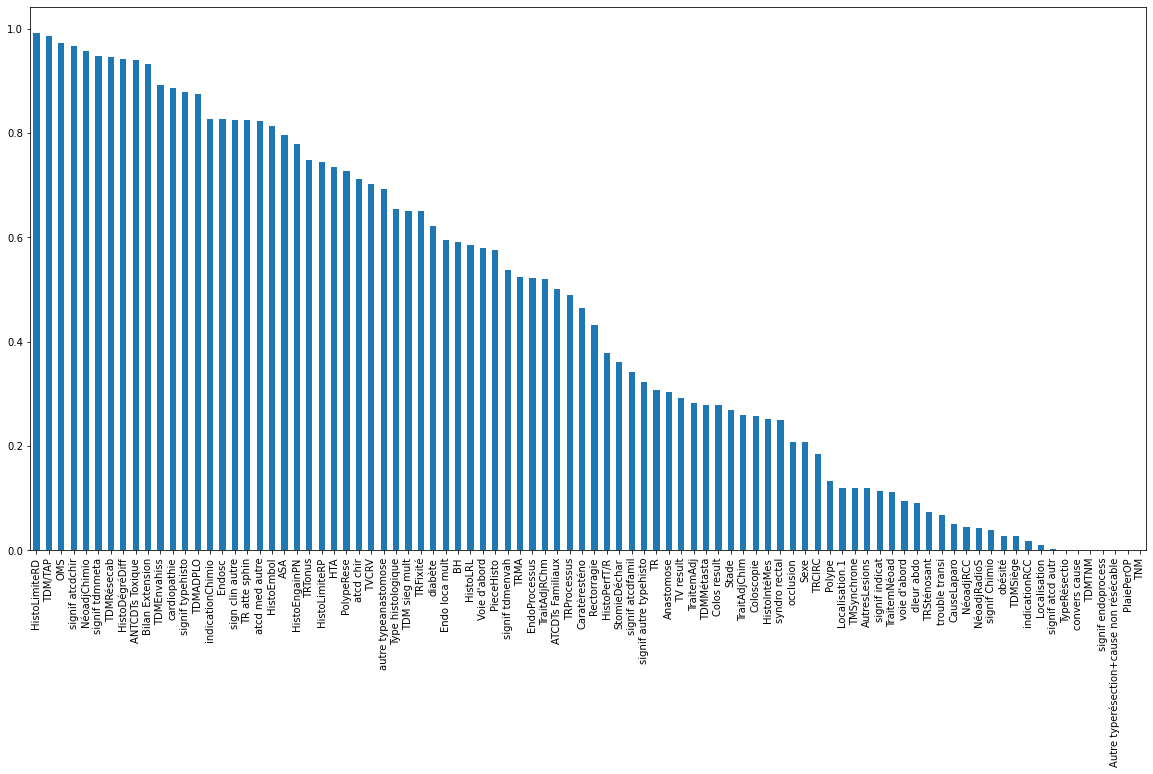

In [48]:
p_values.sort_values(ascending=False).plot.bar(figsize=(20,10))

In [49]:
from sklearn.feature_selection import SelectPercentile

In [50]:
## Selecting the top 25 percentile
selected_top_columns = SelectPercentile(chi2, percentile=25)
selected_top_columns.fit(X_train.fillna(0), y_train)

SelectPercentile(percentile=25,
                 score_func=<function chi2 at 0x000001E36154F0D0>)

In [51]:
X_train.columns[selected_top_columns.get_support()]

Index(['obésité', 'signif atcd autr', 'trouble transi', 'dleur abdo',
       'TRSténosant', 'signif endoprocess', 'Localisation', 'TDMSiège',
       'TDMTNM', 'voie d'abord', 'CauseLaparo', 'TraitemNéoad',
       'signif indicat', 'NéoadjRCC', 'indicationRCC', 'NéoadjRadioS',
       'convers cause', 'PlaiePerOP', 'TypeRésectio',
       'Autre typerésection+cause non résécable', 'TNM', 'signif Chimio'],
      dtype='object')

In [52]:
#mutual information
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.0297708 , 0.        , 0.        , 0.        , 0.04567724,
       0.        , 0.        , 0.01196875, 0.        , 0.        ,
       0.01007173, 0.        , 0.        , 0.        , 0.00842705,
       0.        , 0.        , 0.05565185, 0.        , 0.02542116,
       0.        , 0.06652509, 0.05982207, 0.        , 0.        ,
       0.03527589, 0.0215242 , 0.00014165, 0.        , 0.        ,
       0.        , 0.00509655, 0.        , 0.        , 0.        ,
       0.        , 0.02277326, 0.01022482, 0.03192452, 0.0088944 ,
       0.01259742, 0.02368849, 0.        , 0.04020378, 0.00796648,
       0.0488081 , 0.04723925, 0.02616632, 0.        , 0.00870162,
       0.        , 0.        , 0.        , 0.03137829, 0.        ,
       0.01604014, 0.01639122, 0.0240176 , 0.006961  , 0.03797722,
       0.01852378, 0.02298676, 0.        , 0.02108129, 0.0093888 ,
       0.007655  , 0.00741573, 0.00046778, 0.        , 0.00458713,
       0.03408973, 0.03587093, 0.        , 0.07246373, 0.     

In [53]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

autre typeanastomose    0.072464
TR atte sphin           0.066525
TRMA                    0.059822
sign clin autre         0.055652
TDM/TAP                 0.048808
                          ...   
Anastomose              0.000000
PieceHisto              0.000000
TDMRésecab              0.000000
TRCIRC                  0.000000
TraitAdjRChm            0.000000
Length: 90, dtype: float64

<AxesSubplot:>

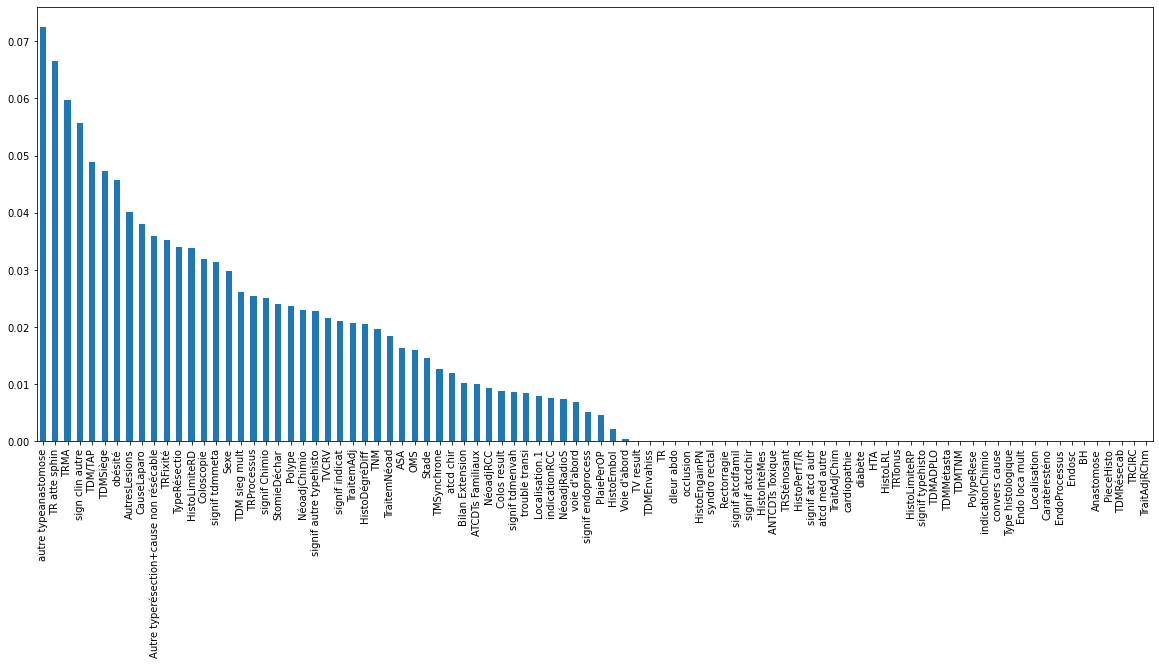

In [54]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [55]:
from sklearn.feature_selection import SelectKBest

In [56]:
#Now we Will select the  top 20 important features
sel_twenty_cols = SelectKBest(mutual_info_classif, k=20)
sel_twenty_cols.fit(X_train, y_train)
X_train.columns[sel_twenty_cols.get_support()]

Index(['ANTCDTs Toxique', 'Rectorragie', 'syndro rectal', 'trouble transi',
       'TR', 'TVCRV', 'Endosc', 'PolypeRese', 'Localisation.1',
       'signif tdmmeta', 'OMS', 'StomieDéchar', 'NéoadjChimio', 'PlaiePerOP',
       'TypeRésectio', 'HistoLimiteRP', 'HistoLimiteRD', 'HistoEngainPN',
       'HistoIntéMes', 'Stade'],
      dtype='object')

In [57]:
#Now we Will select the  top 20 important features
sel_twenty_cols = SelectKBest(chi2, k=20)
sel_twenty_cols.fit(X_train, y_train)
X_train.columns[sel_twenty_cols.get_support()]

Index(['obésité', 'signif atcd autr', 'trouble transi', 'dleur abdo',
       'TRSténosant', 'signif endoprocess', 'Localisation', 'TDMSiège',
       'TDMTNM', 'voie d'abord', 'CauseLaparo', 'NéoadjRCC', 'indicationRCC',
       'NéoadjRadioS', 'convers cause', 'PlaiePerOP', 'TypeRésectio',
       'Autre typerésection+cause non résécable', 'TNM', 'signif Chimio'],
      dtype='object')

In [58]:
quant_data=pd.DataFrame(df, columns=numeric_features)
quant_data


,Age,Hémoglobine,Globule blanc,Plaquette,CRP,Urée,Créat,Glycémie,Albumine,Préalbumine,Protidemie,ACE,CA19-9,Histo Nbgg,Histo ggPosit
0,60.0,11.5,8170.0,331000.0,12.000000,0.36,10.0,0.90,35.601695,0.259902,66.842857,28.68,71.10,25.000000,1.000000
1,80.0,10.7,8680.0,197000.0,16.000000,0.34,9.0,2.31,35.300000,0.230000,74.000000,5.67,26.82,25.000000,5.000000
2,77.0,10.4,3640.0,147000.0,26.860436,0.30,10.0,2.09,37.800000,0.259902,75.000000,71.37,15.10,15.624224,1.417957
3,50.0,16.0,6890.0,157000.0,3.000000,0.52,10.0,1.02,35.601695,0.259902,66.842857,5.90,10.00,14.000000,0.000000
4,72.0,9.5,6730.0,238000.0,10.000000,0.31,7.0,2.75,33.000000,0.040000,60.000000,1.30,2.39,16.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,32.0,12.1,15840.0,572000.0,154.000000,0.19,7.0,0.95,38.000000,0.259902,66.842857,14.51,0.50,22.000000,4.000000
334,56.0,9.5,5060.0,456000.0,37.000000,0.23,5.0,1.07,39.000000,0.259902,66.842857,10.42,0.80,26.000000,0.000000
335,52.0,11.7,7770.0,362000.0,20.000000,0.20,8.0,1.10,44.000000,0.259902,66.842857,5.59,0.80,40.000000,0.000000
336,50.0,11.0,7480.0,330000.0,94.000000,0.11,5.0,1.05,25.000000,0.030000,66.842857,15.59,20.06,20.000000,1.000000


In [59]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components=4)

In [61]:
pca.fit(quant_data)

PCA(n_components=4)

In [62]:
x_pca = pca.transform(quant_data)

In [63]:
quant_data.shape

(338, 15)

In [64]:
x_pca.shape

(338, 4)

In [65]:
quant_data.keys()

Index(['Age', 'Hémoglobine', 'Globule blanc', 'Plaquette', 'CRP', 'Urée',
       'Créat', 'Glycémie', 'Albumine', 'Préalbumine', 'Protidemie', 'ACE',
       'CA19-9', 'Histo Nbgg', 'Histo ggPosit'],
      dtype='object')

Text(0, 0.5, 'Second Principal Component')

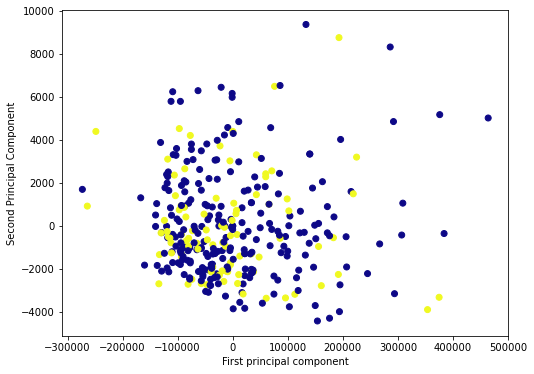

In [66]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['Morbidité'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [67]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

In [68]:
#classe pour standardisation
from sklearn.preprocessing import StandardScaler
#instanciation
sc = StandardScaler()
#transformation – centrage-réduction
Z = sc.fit_transform(quant_data)

#vérification - librairie numpy
import numpy
#moyenne
print(numpy.mean(Z,axis=0))

#écart-type
print(numpy.std(Z,axis=0))

print(Z)

[-4.86133159e-16  7.88324041e-18  9.45988849e-17  1.61606428e-16
 -1.57664808e-17  1.26131847e-16 -3.44234831e-16  1.62920302e-16
 -1.04058773e-15 -5.25549361e-18  1.41898327e-16  3.15329616e-17
  3.15329616e-17  2.20730732e-16 -5.25549361e-18]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 1.99316753e-01 -5.34696883e-02  4.55517988e-01 ...  3.49756562e-01
   1.09426197e+00 -1.12483917e-01]
 [ 1.68424866e+00 -4.61838752e-01  6.32656860e-01 ... -7.25447718e-02
   1.09426197e+00  9.64028830e-01]
 [ 1.46150888e+00 -6.14977151e-01 -1.11789200e+00 ... -1.84319199e-01
   2.07321469e-16  0.00000000e+00]
 ...
 [-3.94656010e-01  4.86225777e-02  3.16585539e-01 ... -3.20699259e-01
   2.84493614e+00 -3.81612104e-01]
 [-5.43149201e-01 -3.08700353e-01  2.15859513e-01 ... -1.37015346e-01
   5.10703914e-01 -1.12483917e-01]
 [-1.80534132e+00 -4.10792619e-01  1.77653090e-01 ... -3.18791846e-01
   1.60569080e-01 -3.81612104e-01]]


In [69]:
#classe pour l'ACP
from sklearn.decomposition import PCA
#instanciation
acp = PCA()

#calculs
coord = acp.fit_transform(Z)
#nombre de composantes calculées
print(acp.n_components_)

15


In [70]:
list_acp = ["CP1","CP2","CP3","CP4","CP5","CP6","CP7","CP8", "CP9", "CP10", "CP11", "CP12", "CP13", "CP14", "CP15"]
df_acp = pd.DataFrame(list_acp, columns = ["ACP"])
df_acp['explained_variance'] = acp.explained_variance_

<AxesSubplot:xlabel='explained_variance', ylabel='ACP'>

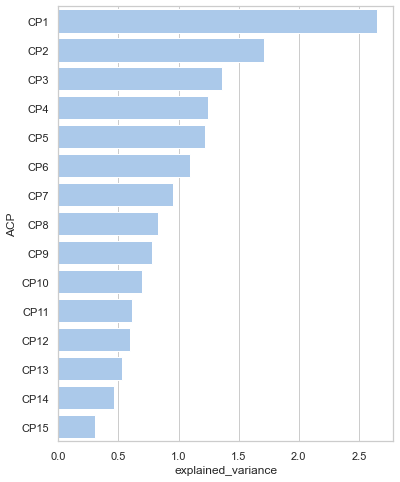

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 8))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="explained_variance", y="ACP", data=df_acp,
            label="Total", color="b")

La plus grande quantité d'information est toujours représenté par notre première composante.

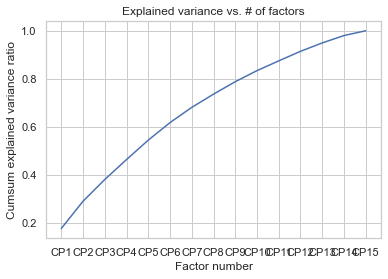

In [72]:
#cumul de variance expliquée
#La fonction .cumsum() : pour avoir la quantité de variance expliquée de façon cumulative
plt.plot(list_acp,numpy.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

Bien que la 13 ème composante représente 95% de l'information, nous prendrons 13 composantes
afin de pouvoir réaliser une projection et une analyse dans ce plan

In [73]:
#calcule des carrés des distances à l’origine des individus, qui correspondent également à leur contribution dans l’inertie totale.
di = np.sum(Z**2,axis=1)
df_ctr_ind = pd.DataFrame({'ID':quant_data.index,'d_i':di})
df_ctr_ind

,ID,d_i
0,0,5.945947
1,1,19.070795
2,2,35.575363
3,3,13.724070
4,4,24.938139
...,...,...
333,333,29.825944
334,334,7.755168
335,335,12.405268
336,336,11.189675


In [74]:
#Filtrer les individus avec d_i > à la moyenne de d_i
df_ctr_ind[df_ctr_ind['d_i'] > df_ctr_ind.d_i.mean()]

,ID,d_i
1,1,19.070795
2,2,35.575363
4,4,24.938139
12,12,18.783653
21,21,46.640710
...,...,...
303,303,28.922257
307,307,18.180318
312,312,31.756582
313,313,53.532894


63 individus pourront être exploité; car seul les individus avec une contribution supérieur à la moyenne seront interprétables

Nous allons calculer la contribution de chaque individus dans notre plan CP1, CP2,.....,CP9

In [75]:
#contributions aux axes
eigval = (338-1)/338*acp.explained_variance_ # represent the amount of variance explained

#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((15,15))
for k in range(15):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs
print(pd.DataFrame(corvar))

          0         1         2         3         4         5         6   \
0  -0.137304  0.663048 -0.202298 -0.086901  0.018323 -0.246373 -0.038950   
1  -0.567747 -0.133652 -0.018658  0.248765 -0.174302 -0.174456 -0.455315   
2   0.695782 -0.007859  0.059506  0.421215 -0.275718 -0.016273 -0.193708   
3   0.754289 -0.124442  0.043898  0.209815 -0.021294  0.150948  0.145254   
4   0.653284  0.000175  0.025240  0.265105 -0.256107  0.170863 -0.254665   
5  -0.139727  0.587700 -0.024854  0.439506 -0.186448 -0.201799  0.006316   
6  -0.206152  0.321918  0.248038  0.511529  0.020224 -0.193086  0.492968   
7  -0.121605  0.413707  0.434779  0.042827  0.325571  0.342299 -0.219632   
8  -0.535611 -0.430478  0.241449  0.379124 -0.093184  0.005183 -0.120951   
9  -0.122609  0.205151  0.283297  0.172759  0.395200  0.533155  0.011255   
10 -0.320389 -0.546008  0.361610  0.144381 -0.052908 -0.011136  0.251460   
11  0.187206  0.174278  0.663163 -0.356351 -0.177894 -0.061888 -0.186947   
12  0.196610

In [76]:
#on affiche pour les deux premiers axes
print(pd.DataFrame({'id':quant_data.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

               id     COR_1     COR_2
0             Age -0.137304  0.663048
1     Hémoglobine -0.567747 -0.133652
2   Globule blanc  0.695782 -0.007859
3       Plaquette  0.754289 -0.124442
4             CRP  0.653284  0.000175
5            Urée -0.139727  0.587700
6           Créat -0.206152  0.321918
7        Glycémie -0.121605  0.413707
8        Albumine -0.535611 -0.430478
9     Préalbumine -0.122609  0.205151
10     Protidemie -0.320389 -0.546008
11            ACE  0.187206  0.174278
12         CA19-9  0.196610  0.055387
13     Histo Nbgg  0.489983 -0.179537
14  Histo ggPosit  0.165134 -0.137627


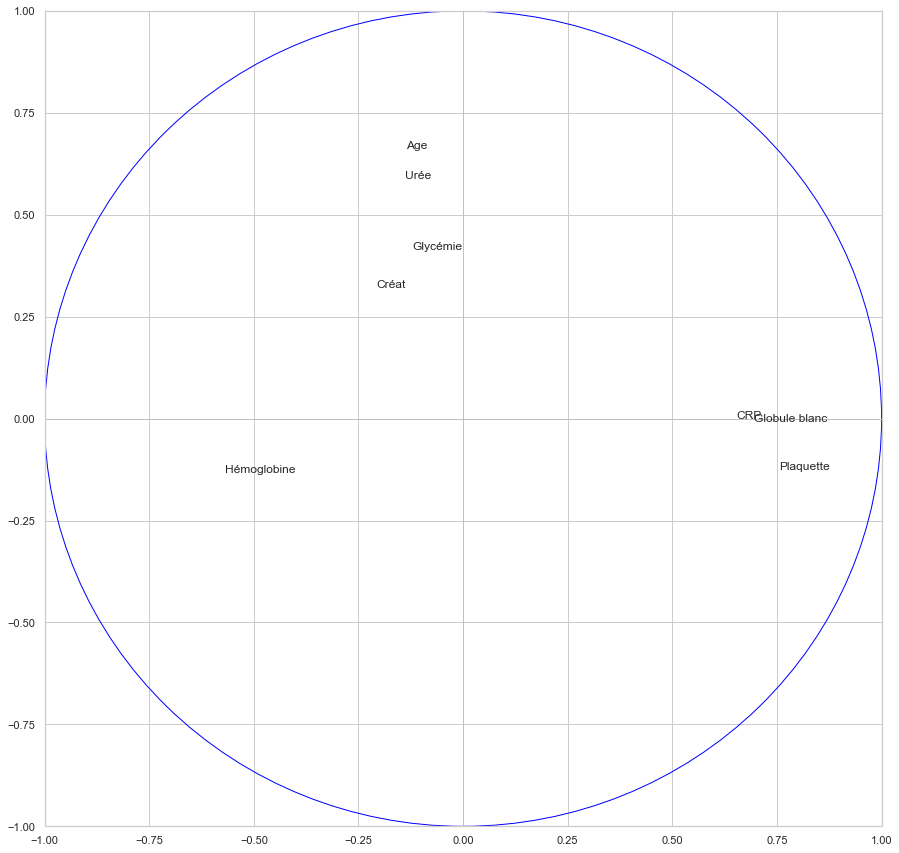

In [77]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(15,15))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(8):
    plt.annotate(quant_data.columns[j],(corvar[j,0],corvar[j,1]))

#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#affichage
plt.show()


In [78]:
#Filtrer les variables avec un taux de représentation supérier à la moyenne sur CP1
#cosinus carré des variables
cos2var = corvar**2
df_ctr_variables = pd.DataFrame({'id':quant_data.columns,'COS9_1':cos2var[:,0],'COS9_2':cos2var[:,1],'COS9_3':cos2var[:,2],'COS9_4':cos2var[:,3],'COS9_5':cos2var[:,4],'COS9_6':cos2var[:,5], 'COS9_7':cos2var[:,6],'COS9_8':cos2var[:,7],'COS9_9':cos2var[:,8]})

In [79]:
df_ctr_variables[df_ctr_variables['COS9_1'] > df_ctr_variables['COS9_1'].mean()]

,id,COS9_1,COS9_2,COS9_3,COS9_4,COS9_5,COS9_6,COS9_7,COS9_8,COS9_9
1,Hémoglobine,0.322337,1.786287e-02,0.000348,0.061884,0.030381,0.030435,0.207312,0.025670,0.072477
2,Globule blanc,0.484113,6.176261e-05,0.003541,0.177422,0.076021,0.000265,0.037523,0.005156,0.000192
3,Plaquette,0.568952,1.548582e-02,0.001927,0.044022,0.000453,0.022785,0.021099,0.018879,0.056269
4,CRP,0.426780,3.049562e-08,0.000637,0.070280,0.065591,0.029194,0.064854,0.011960,0.000552
8,Albumine,0.286879,1.853113e-01,0.058297,0.143735,0.008683,0.000027,0.014629,0.005624,0.014734
13,Histo Nbgg,0.240084,3.223346e-02,0.000074,0.007536,0.273216,0.082011,0.040315,0.002878,0.068525


In [80]:
#Filtrer les variables avec un taux de représentation supérier à la moyenne sur CP2
df_ctr_variables[df_ctr_variables['COS9_2'] > df_ctr_variables['COS9_2'].mean()]

,id,COS9_1,COS9_2,COS9_3,COS9_4,COS9_5,COS9_6,COS9_7,COS9_8,COS9_9
0,Age,0.018852,0.439633,0.040925,0.007552,0.000336,0.060700,0.001517,0.012969,0.184190
5,Urée,0.019524,0.345392,0.000618,0.193165,0.034763,0.040723,0.000040,0.021105,0.009541
7,Glycémie,0.014788,0.171154,0.189033,0.001834,0.105997,0.117169,0.048238,0.181624,0.007480
8,Albumine,0.286879,0.185311,0.058297,0.143735,0.008683,0.000027,0.014629,0.005624,0.014734
10,Protidemie,0.102649,0.298124,0.130761,0.020846,0.002799,0.000124,0.063232,0.008457,0.167520


In [81]:
#Filtrer les variables avec un taux de représentation supérier à la moyenne sur CP3
df_ctr_variables[df_ctr_variables['COS9_3'] > df_ctr_variables['COS9_3'].mean()]

,id,COS9_1,COS9_2,COS9_3,COS9_4,COS9_5,COS9_6,COS9_7,COS9_8,COS9_9
7,Glycémie,0.014788,0.171154,0.189033,0.001834,0.105997,0.117169,0.048238,0.181624,0.007480
10,Protidemie,0.102649,0.298124,0.130761,0.020846,0.002799,0.000124,0.063232,0.008457,0.167520
11,ACE,0.035046,0.030373,0.439785,0.126986,0.031646,0.003830,0.034949,0.040122,0.060912
12,CA19-9,0.038656,0.003068,0.340236,0.074609,0.054151,0.156849,0.014063,0.146619,0.017672


In [82]:
#Filtrer les variables avec un taux de représentation supérier à la moyenne sur CP4
df_ctr_variables[df_ctr_variables['COS9_4'] > df_ctr_variables['COS9_4'].mean()]

,id,COS9_1,COS9_2,COS9_3,COS9_4,COS9_5,COS9_6,COS9_7,COS9_8,COS9_9
2,Globule blanc,0.484113,0.000062,0.003541,0.177422,0.076021,0.000265,0.037523,0.005156,0.000192
5,Urée,0.019524,0.345392,0.000618,0.193165,0.034763,0.040723,0.000040,0.021105,0.009541
6,Créat,0.042499,0.103631,0.061523,0.261661,0.000409,0.037282,0.243017,0.000102,0.089327
8,Albumine,0.286879,0.185311,0.058297,0.143735,0.008683,0.000027,0.014629,0.005624,0.014734
11,ACE,0.035046,0.030373,0.439785,0.126986,0.031646,0.003830,0.034949,0.040122,0.060912


In [83]:
#modalités de la variable qualitative
modalites = numpy.unique(df.Morbidité)
print(modalites)

[0. 1.]


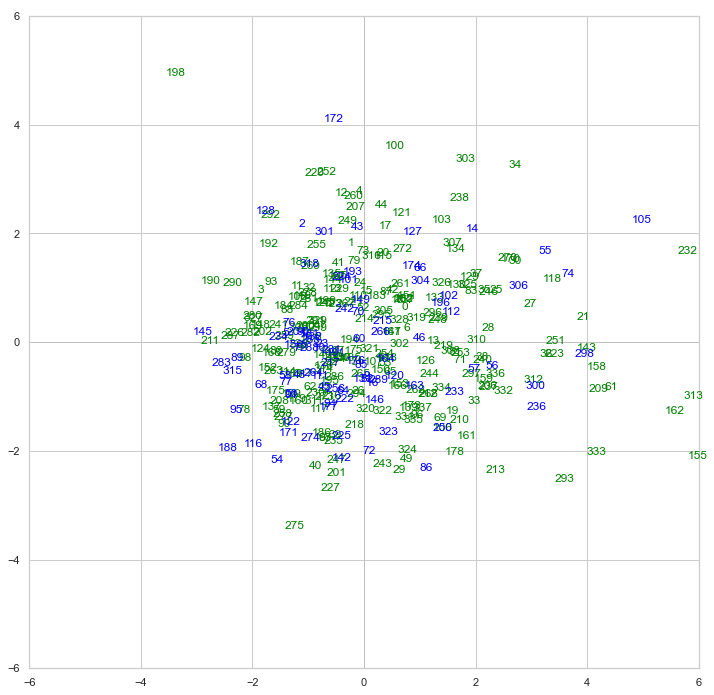

In [84]:
#Nous représentons les individus dans le plan factoriel, coloriées selon la modalité associée de la variable illustrative.
#liste des couleurs
couleurs = ['green','blue']

#faire un graphique en coloriant les points
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6)
axes.set_ylim(-6,6)

#pour chaque modalité de la var. illustrative
for c in range(len(modalites)):
 #numéro des individus concernés
 numero = numpy.where(df.Morbidité == modalites[c])
 #les passer en revue pour affichage
 for i in numero[0]:
    plt.annotate(quant_data.index[i],(coord[i,0],coord[i,1]),color=couleurs[c])

#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)

#affichage
plt.show()


In [85]:
pca = PCA(random_state=None)
pca_df = pca.fit_transform(Z)
v_ratio = np.cumsum(pca.explained_variance_ratio_)
v_ratio

array([0.17623065, 0.28978779, 0.38031325, 0.46329519, 0.54428161,
       0.61727292, 0.68065174, 0.73577347, 0.78771277, 0.83381186,
       0.87443717, 0.9142806 , 0.94928054, 0.97994398, 1.        ])

In [86]:
y=df.Morbidité
inc_pca = IncrementalPCA(n_components=2)
pca_df = inc_pca.fit_transform(Z)
pca_df = pd.DataFrame(pca_df, columns=['PC_1','PC_2'])
pca_df = pd.concat([pca_df,y], axis=1)
pca_df.head()

,PC_1,PC_2,Morbidité
0,0.870302,0.614121,0.0
1,-0.111242,1.265575,0.0
2,-0.590388,2.798037,1.0
3,-1.674114,-0.074809,0.0
4,0.122198,1.161117,0.0


In [87]:
indexNames1 = pca_df[pca_df['Morbidité'].isna()].index
pca_df.drop(indexNames1 , inplace=True)
pca_df.head()

,PC_1,PC_2,Morbidité
0,0.870302,0.614121,0.0
1,-0.111242,1.265575,0.0
2,-0.590388,2.798037,1.0
3,-1.674114,-0.074809,0.0
4,0.122198,1.161117,0.0


In [88]:
data.info

<bound method DataFrame.info of          N  Sexe  HTA  diabète  cardiopathie  obésité  atcd med autre  \
0      1.0     1  0.0      0.0           0.0      0.0             0.0   
1      2.0     0  0.0      0.0           0.0      0.0             0.0   
2      3.0     1  1.0      0.0           0.0      0.0             0.0   
3      4.0     0  0.0      0.0           0.0      0.0             0.0   
4      6.0     0  1.0      0.0           0.0      0.0             0.0   
..     ...   ...  ...      ...           ...      ...             ...   
333  342.0     0  0.0      0.0           0.0      0.0             0.0   
334  343.0     1  0.0      0.0           0.0      0.0             1.0   
335  344.0     1  0.0      0.0           0.0      0.0             0.0   
336  345.0     1  0.0      0.0           0.0      0.0             0.0   
337  346.0     1  0.0      0.0           0.0      0.0             0.0   

     signif atcd autr  atcd chir  signif atcdchir  ...  CHemorEvolu  \
0                   

In [89]:
allData= pd.concat([quant_data, data], axis=1)

In [90]:
allData= pd.concat([quant_data, data], axis=1)

In [91]:
allData

,Age,Hémoglobine,Globule blanc,Plaquette,CRP,Urée,Créat,Glycémie,Albumine,Préalbumine,...,CHemorEvolu,CpltPérinéal,CPérinéDiagnos,CPérinTraite,CPérinEvolut,CplUrinair,CUrinaiDiagn,CUrinairEvolu,Cplct Générl,Décès
0,60.0,11.5,8170.0,331000.0,12.000000,0.36,10.0,0.90,35.601695,0.259902,...,0,0.0,0,0,0,0.0,0,0,0.0,0
1,80.0,10.7,8680.0,197000.0,16.000000,0.34,9.0,2.31,35.300000,0.230000,...,0,0.0,0,0,0,0.0,0,0,0.0,0
2,77.0,10.4,3640.0,147000.0,26.860436,0.30,10.0,2.09,37.800000,0.259902,...,0,0.0,0,0,0,0.0,0,0,0.0,0
3,50.0,16.0,6890.0,157000.0,3.000000,0.52,10.0,1.02,35.601695,0.259902,...,0,0.0,0,0,0,0.0,0,0,0.0,1
4,72.0,9.5,6730.0,238000.0,10.000000,0.31,7.0,2.75,33.000000,0.040000,...,0,0.0,0,0,0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,32.0,12.1,15840.0,572000.0,154.000000,0.19,7.0,0.95,38.000000,0.259902,...,0,0.0,0,0,0,0.0,0,0,0.0,0
334,56.0,9.5,5060.0,456000.0,37.000000,0.23,5.0,1.07,39.000000,0.259902,...,0,0.0,0,0,0,0.0,0,0,0.0,1
335,52.0,11.7,7770.0,362000.0,20.000000,0.20,8.0,1.10,44.000000,0.259902,...,0,0.0,0,0,0,0.0,0,0,0.0,1
336,50.0,11.0,7480.0,330000.0,94.000000,0.11,5.0,1.05,25.000000,0.030000,...,0,0.0,0,0,0,0.0,0,0,0.0,2


In [92]:
data['TNM']

0       0
1       1
2       2
3       3
4       3
       ..
333    62
334     2
335    39
336    63
337     6
Name: TNM, Length: 338, dtype: int64

ACP & ACM

In [93]:
allData= pd.concat([quant_data, data], axis=1)
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Columns: 158 entries, Age to Décès
dtypes: float64(116), int32(1), int64(41)
memory usage: 416.0 KB


### Data preprocessing

In [94]:
possible_features1=[]
for col in allData.columns[allData.columns.get_loc('Age'):allData.columns.get_loc("DécèsPostOP")]:
    possible_features1.append(col)
X_Train, X_Test, y_Train, y_Test=train_test_split(allData[possible_features1],
                                              data['Morbidité'],test_size=0.2,random_state=1)

In [95]:
X_Train

,Age,Hémoglobine,Globule blanc,Plaquette,CRP,Urée,Créat,Glycémie,Albumine,Préalbumine,...,HistoEmbol,HistoEngainPN,HistoIntéMes,HistoPerfT/R,TNM,Stade,TraitemAdj,TraitAdjChim,signif Chimio,TraitAdjRChm
310,54.0,12.0,11220.0,443000.0,94.0,0.19,8.0,1.790000,34.000000,0.030000,...,0.0,0.0,0.0,0.0,2,2,0.0,0.0,7,0.0
85,60.0,14.9,5140.0,187000.0,140.0,0.25,8.0,0.860000,35.601695,0.259902,...,1.0,0.0,0.0,2.0,4,3,1.0,1.0,0,0.0
73,67.0,8.2,7420.0,187000.0,5.0,0.46,7.0,1.077961,34.000000,0.010000,...,2.0,2.0,0.0,2.0,2,2,0.0,0.0,0,0.0
286,47.0,11.7,6490.0,187000.0,0.0,0.18,7.0,1.110000,34.000000,0.259902,...,2.0,2.0,1.0,2.0,30,1,0.0,0.0,0,0.0
302,63.0,10.1,5320.0,281000.0,8.0,0.18,7.0,1.050000,34.000000,0.259902,...,2.0,2.0,0.0,2.0,60,3,1.0,1.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,52.0,11.6,6550.0,193000.0,1.0,0.19,7.0,0.960000,33.000000,0.030000,...,2.0,2.0,1.0,2.0,30,1,0.0,0.0,0,0.0
255,55.0,10.8,4140.0,225000.0,4.0,0.44,8.0,1.380000,38.000000,0.259902,...,2.0,2.0,1.0,2.0,6,0,0.0,0.0,0,0.0
72,38.0,13.6,10007.0,183000.0,36.0,0.17,7.0,0.860000,35.601695,0.259902,...,2.0,1.0,0.0,2.0,15,3,1.0,1.0,0,0.0
235,41.0,10.5,5040.0,244000.0,10.0,0.28,6.0,0.610000,42.000000,0.050000,...,0.0,0.0,0.0,0.0,2,2,1.0,1.0,1,0.0


In [96]:
sm = SMOTE(random_state = 666)

# New training dataset with smote applied to it
X_train_s, y_train_s = sm.fit_resample(X_Train, y_Train.ravel())

Text(1, 99.0, '199.0')

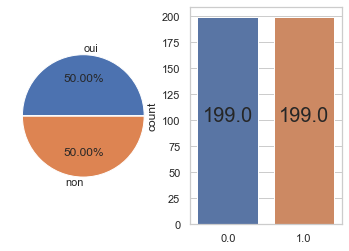

In [97]:
plt.subplot(121)
plt.pie(x = [len(y_train_s)- sum(y_train_s), sum(y_train_s)],
        labels = ["oui", "non"], autopct='%1.2f%%', explode = (0, 0.01))

plt.subplot(122)
sns.countplot(x = y_train_s)
fraudnt_s, fraud_s = len(y_train_s)- sum(y_train_s), sum(y_train_s)
plt.text(0, fraudnt_s//2, fraudnt_s, fontsize = 20,  horizontalalignment='center')
plt.text(1, fraud_s//2, fraud_s, fontsize = 20, horizontalalignment='center')

In [98]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X_train_s,y_train_s, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2


,CV Mean,Std
Linear Svm,0.535064,0.091501
Radial Svm,0.255000,0.188348
Logistic Regression,0.530192,0.107111
KNN,0.600449,0.069522
Decision Tree,0.711859,0.130769
Naive Bayes,0.594744,0.231664
Random Forest,0.842436,0.115062


### Dimensionality reduction : Applying PCA&MCA

In [99]:
# separate numerical and categorical features into different datasets
X_train_s_num = X_train_s.copy()
X_train_s_cat = X_train_s.copy()
X_Test_num = X_Test.copy()
X_Test_cat = X_Test.copy()
print(X_Test_num.shape)
print(X_Test_cat.shape)
for num in X_train_s_num.columns:
    if num in data.columns.tolist():
        del(X_train_s_num[num])
for cat in X_train_s_cat.columns:
    if cat in quant_data.columns.tolist():
        del(X_train_s_cat[cat])
        
for i in X_Test_num.columns:
    if i in data.columns.tolist():
        del(X_Test_num[i])
for j in X_Test_cat.columns:
    if j in quant_data.columns.tolist():
        del(X_Test_cat[j])


(68, 107)
(68, 107)


In [100]:
# scale numerical data before applying PCA       
scaler= StandardScaler() 
scaler.fit(X_train_s_num)      # fit scaler on train set
X_train_s_num = pd.DataFrame(scaler.transform(X_train_s_num)) # transform train set
X_Test_num = pd.DataFrame(scaler.transform(X_Test_num)) # transform validation set

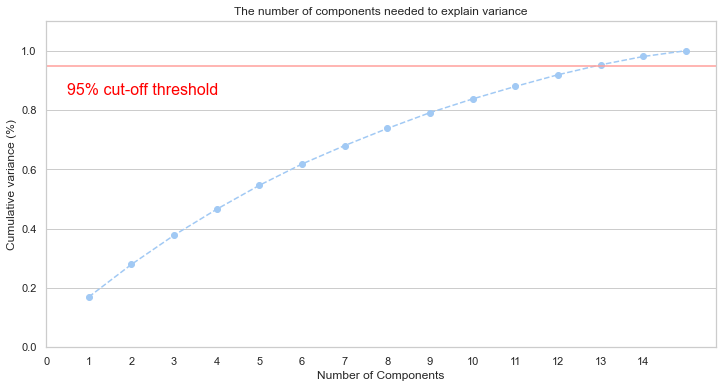

In [101]:
#choose best number of components for pca
pca = PCA().fit(X_train_s_num)


import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 15, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

On the plotted chart, we see what number of principal components we need. In this case, to get 95% of variance explained we need 13 principal components

In [102]:
#create hyperparameter set
           # parameter in ridge regression
n_pca_components =[13]                   # for n_components parameter in KernelPCA
             # wrapper for rbf and sigmoid KernelPCA model
   # parameter in KernelPCA
n_mca_components = [i for i in range(1,92)]           # for n_components parameter in MCA
n_iters = np.logspace(1,2,3, dtype=int) # for n_iter parameter in MCA

hyperparam_set = list(itertools.product( n_pca_components, n_mca_components, n_iters))

In [103]:
#X_train_s_cat.to_excel(r'C:\Users\user\Documents\X_train_s_cat.xlsx', index = False)

#### Building a wrapper to select the best model and best hyperparameter set

#### Logistic regression

In [104]:
valid_score =[]     # initialize a list to store validation score

for params in hyperparam_set:  
    # train PCA on numerical data
    pca = PCA(n_components = params[0]) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=params[1], n_iter=params[2], copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
    # fit logistic regression on dimensally reduced components (i.e. PCA+MCA)
    lr= LogisticRegression()
    lr.fit(X_train_s, y_train_s)
    valid_score.append(metrics.mean_squared_error(lr.predict(X_Test), y_Test))

print('best hyperparameter set for logistic regression:', hyperparam_set[np.argmin(valid_score)])
print('MSE on validation set:', min(valid_score))

   
    

best hyperparameter set for logistic regression: (13, 25, 10)
MSE on validation set: 0.27941176470588236


In [105]:



    # train PCA on numerical data
    pca = PCA(n_components = 13) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=25, n_iter=10, copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    


X_train_s_lr= X_train_s.copy()
X_Test_lr=X_Test.copy()
   

In [106]:
X_train_s_lr.shape

(398, 38)

#### Random forest

In [107]:
valid_score1 =[]     # initialize a list to store validation score
for params in hyperparam_set:  
    # train PCA on numerical data
    pca = PCA(n_components = params[0]) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=params[1], n_iter=params[2], copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
    # fit random forest on dimensally reduced components (i.e. PCA+MCA)
    clf=RandomForestClassifier()
    clf.fit(X_train_s, y_train_s)
    valid_score1.append(metrics.mean_squared_error(clf.predict(X_Test), y_Test))

print('best hyperparameter set for random forest:', hyperparam_set[np.argmin(valid_score1)])
print('MSE on validation set:', min(valid_score1))


   

best hyperparameter set for random forest: (13, 52, 31)
MSE on validation set: 0.19117647058823528


In [108]:

    # train PCA on numerical data
    pca = PCA(n_components = 13) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=60, n_iter=31, copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
   

    X_train_s_rf= X_train_s.copy()
    X_Test_rf=X_Test.copy()

In [109]:
X_train_s_rf.shape

(398, 73)

#### Desicion Tree

In [110]:
valid_score2 =[]     # initialize a list to store validation score
for params in hyperparam_set:  
    # train PCA on numerical data
    pca = PCA(n_components = params[0]) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=params[1], n_iter=params[2], copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
    # fit random forest on dimensally reduced components (i.e. PCA+MCA)
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train_s, y_train_s)
    valid_score2.append(metrics.mean_squared_error(dtc.predict(X_Test), y_Test))

print('best hyperparameter set for decision tree :', hyperparam_set[np.argmin(valid_score2)])
print('MSE on validation set:', min(valid_score2))


best hyperparameter set for decision tree : (13, 32, 31)
MSE on validation set: 0.29411764705882354


In [111]:
 # train PCA on numerical data
pca = PCA(n_components = 13) 
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
mca = prince.MCA(n_components=33, n_iter=31, copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
X_train_mca = X_train_mca.reset_index(drop=True)
X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)

X_train_s_dt= X_train_s.copy()
X_Test_dt=X_Test.copy()

In [112]:
X_train_s_dt.shape

(398, 46)

#### K-Nearest Neighbors

In [113]:
valid_score3 =[]     # initialize a list to store validation score
for params in hyperparam_set:  
    # train PCA on numerical data
    pca = PCA(n_components = params[0]) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=params[1], n_iter=params[2], copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
    # fit random forest on dimensally reduced components (i.e. PCA+MCA)
    knn = KNeighborsClassifier()
    knn.fit(X_train_s, y_train_s)
    valid_score3.append(metrics.mean_squared_error(knn.predict(X_Test), y_Test))

print('best hyperparameter set for KNN :', hyperparam_set[np.argmin(valid_score3)])
print('MSE on validation set:', min(valid_score3))

   

best hyperparameter set for KNN : (13, 2, 10)
MSE on validation set: 0.4264705882352941


In [114]:
    # train PCA on numerical data
    pca = PCA(n_components = 13) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=2, n_iter=10, copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
X_train_s_knn= X_train_s.copy()
X_Test_knn=X_Test.copy()

In [115]:
X_train_s_knn.shape

(398, 15)

#### Support Vector Machines linear

In [116]:
from sklearn import svm
valid_score4 =[]     # initialize a list to store validation score
for params in hyperparam_set:  
    # train PCA on numerical data
    pca = PCA(n_components = params[0]) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=params[1], n_iter=params[2], copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
    # fit random forest on dimensally reduced components (i.e. PCA+MCA)
    classifier_svm= svm.SVC(kernel='linear')
    classifier_svm.fit(X_train_s, y_train_s)
    valid_score4.append(metrics.mean_squared_error(classifier_svm.predict(X_Test), y_Test))

print('best hyperparameter set for SVM :', hyperparam_set[np.argmin(valid_score4)])
print('MSE on validation set:', min(valid_score4))


best hyperparameter set for SVM : (13, 29, 10)
MSE on validation set: 0.29411764705882354


In [117]:
 
    # train PCA on numerical data
    pca = PCA(n_components = 13) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=29, n_iter=10, copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
X_train_s_svml= X_train_s.copy()
X_Test_svml=X_Test.copy()

In [118]:
X_train_s_svml.shape

(398, 42)

#### Support Vector Machines rbf

In [119]:
from sklearn import svm
valid_score5 =[]     # initialize a list to store validation score
for params in hyperparam_set:  
    # train PCA on numerical data
    pca = PCA(n_components = params[0]) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=params[1], n_iter=params[2], copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
    # fit random forest on dimensally reduced components (i.e. PCA+MCA)
    classifier_svm_rbf= svm.SVC(kernel='rbf')
    classifier_svm_rbf.fit(X_train_s, y_train_s)
    valid_score5.append(metrics.mean_squared_error(classifier_svm_rbf.predict(X_Test), y_Test))

print('best hyperparameter set for SVM :', hyperparam_set[np.argmin(valid_score5)])
print('MSE on validation set:', min(valid_score5))


   

best hyperparameter set for SVM : (13, 15, 10)
MSE on validation set: 0.4117647058823529


In [120]:
     # train PCA on numerical data
pca = PCA(n_components = 13) 
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
mca = prince.MCA(n_components=15, n_iter=10, copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
X_train_mca = X_train_mca.reset_index(drop=True)
X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
X_train_s_rbf= X_train_s.copy()
X_Test_rbf=X_Test.copy()
   

In [121]:
X_train_s_rbf.shape

(398, 28)

#### Naive Bayes

In [122]:
from sklearn.naive_bayes import GaussianNB
valid_score6 =[]     # initialize a list to store validation score
for params in hyperparam_set:  
    # train PCA on numerical data
    pca = PCA(n_components = params[0]) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=params[1], n_iter=params[2], copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)
    
    # fit random forest on dimensally reduced components (i.e. PCA+MCA)
    model = GaussianNB()
    model.fit(X_train_s, y_train_s)
    valid_score6.append(metrics.mean_squared_error(model.predict(X_Test), y_Test))

print('best hyperparameter set for SVM :', hyperparam_set[np.argmin(valid_score6)])
print('MSE on validation set:', min(valid_score6))



best hyperparameter set for SVM : (13, 27, 10)
MSE on validation set: 0.39705882352941174


In [123]:

    # train PCA on numerical data
    pca = PCA(n_components = 13) 
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_s_num))
    X_Test_pca = pd.DataFrame(pca.transform(X_Test_num))
    
    # train MCA on categorical data
    mca = prince.MCA(n_components=27, n_iter=10, copy=True, check_input=True, benzecri=False, 
                 random_state= 1, engine='auto')
    mca=mca.fit(X_train_s_cat)        # fit MCA on X_train_cat data
    
    X_train_mca = mca.transform(X_train_s_cat)     # tranform X_train_cat data on MCA
    X_Test_mca = mca.transform(X_Test_cat)     # tranform X_Test_cat data on MCA
    
    # StandardScaler reset the row indexes. 
    # Therefore we need to reset the index for MCA components too. As we need to combine these two datasets (PCA+MCA)
    X_train_mca = X_train_mca.reset_index(drop=True)
    X_Test_mca = X_Test_mca.reset_index(drop=True)
    
    # combine PCA and MCA to form complete training dataset
    X_train_s = pd.concat([X_train_pca, X_train_mca], axis=1, ignore_index=True)
    X_Test = pd.concat([X_Test_pca, X_Test_mca], axis=1, ignore_index=True)

X_train_s_nb= X_train_s.copy()
X_Test_nb=X_Test.copy()


In [124]:
X_train_s_nb.shape

(398, 40)

In [125]:
X_train_sL=[X_train_s_nb, X_train_s_lr, X_train_s_dt, X_train_s_rf, X_train_s_svml, X_train_s_rbf, X_train_s_knn]

In [126]:
X_TestL=[X_Test_nb, X_Test_lr, X_Test_dt, X_Test_rf, X_Test_svml, X_Test_rbf, X_Test_knn]

    feature  importance_score
29       29          2.102151
53       53          1.477537
13       13          1.473921
26       26          1.406793
59       59          1.218158
31       31          1.197422
58       58          0.911348
33       33          0.808987
27       27          0.681487
41       41          0.588306


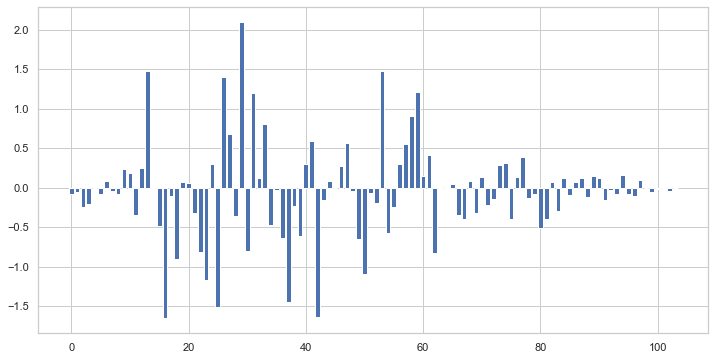

In [127]:
from matplotlib import pyplot
# get importance
importance_ = lr.coef_[0]
train_features=[]
scoreimp=[]
# summarize feature importance
for i,v in enumerate(importance_):
        train_features.append(i)
        scoreimp.append(v)
initial_imp = pd.DataFrame({'feature':train_features,
                          'importance_score':scoreimp})

initial_imp.sort_values('importance_score', ascending=False, inplace=True)
print(initial_imp.head(10))
# plot feature importance
pyplot.bar([x for x in range(len(importance_))], importance_)
pyplot.show()

### Data augmentation

In [128]:
y_train_s=pd.DataFrame(y_train_s, columns=['Morbidité'])
#y_train_s = y_train_s.reset_index(drop=True)

In [129]:
trainL=[]
for i in X_train_sL: 
    trainL.append(pd.concat([i, y_train_s], axis=1))

In [130]:
from tqdm import tqdm_notebook as tqdm
train_augL=[]
for train in trainL:
        a = np.arange(0, train.shape[1])
   #initialise aug dataframe - remember to set dtype!
        train_aug=pd.DataFrame(index=train.index, columns=train.columns, dtype='float64')

        for i in tqdm(range(0, len(train))):
    #ratio of features to be randomly sampled
               AUG_FEATURE_RATIO = 0.5
    #to integer count
               AUG_FEATURE_COUNT = np.floor(train.shape[1]*AUG_FEATURE_RATIO).astype('int16')
    
    #randomly sample half of columns that will contain random values
               aug_feature_index = np.random.choice(train.shape[1], AUG_FEATURE_COUNT, replace=False)
               aug_feature_index.sort()
    
    #obtain indices for features not in aug_feature_index
               feature_index = np.where(np.logical_not(np.in1d(a, aug_feature_index)))[0]
    
    #first insert real values for features in feature_index
               train_aug.iloc[i, feature_index] = train.iloc[i, feature_index]
              
    #random row index to randomly sampled values for each features
               rand_row_index = np.random.choice(len(train), len(aug_feature_index), replace=True)
        
    #for each feature being randomly sampled, extract value from random row in train
               for n, j in enumerate(aug_feature_index):
                    train_aug.iloc[i, j] = train.iloc[rand_row_index[n], j]
        train_augL.append(train_aug)  
      

###### Comparing the first few rows of the regular data and the augmented data:

In [131]:
train_augL[1].head(3)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,Morbidité
0,1.929418,-0.236952,1.504997,0.131928,-0.237144,1.266273,-0.817855,0.861921,-0.241357,-0.086469,...,0.146868,-0.027837,0.324181,0.114397,0.012775,0.065125,0.077422,-0.083349,-0.060502,1.0
1,-0.987648,-0.712824,0.361380,1.589224,0.517088,-0.719247,-2.109890,1.350339,0.011535,-1.460100,...,0.037208,0.181701,-0.007998,0.351958,-0.133054,-0.109133,-0.174909,0.267178,0.047854,1.0
2,0.065227,1.745284,-0.237275,-0.195242,-0.424475,-0.431071,0.330844,-0.758898,-2.110629,0.697149,...,0.171678,-0.000600,-0.270147,-0.177382,0.514932,-0.040423,-0.017044,0.002403,0.069927,0.0


In [132]:
trainL[1].head(3)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,Morbidité
0,1.929418,-0.619798,1.504997,0.131928,-0.237144,1.266273,-0.817855,-0.664623,-0.241357,-0.768560,...,0.146868,0.363563,0.324181,-0.105389,-0.011089,0.065125,0.010223,-0.083349,-0.060502,0.0
1,-0.169203,-0.712824,0.361380,-0.417538,0.517088,-0.719247,-2.109890,1.350339,0.011535,-1.460100,...,-0.118686,0.181701,0.121707,-0.051669,-0.171941,-0.223483,-0.174909,0.267178,0.047854,1.0
2,0.065227,1.745284,-0.237275,-0.195242,-0.424475,-0.224401,0.606055,-0.758898,-0.782879,0.697149,...,-0.094228,0.034253,-0.270147,0.009383,-0.003631,-0.040423,-0.017044,0.034656,0.069927,0.0


We can see, for a basic sanity check, that for each row in train_aug that half the values are the same as in x_train, and the remaining half are seemingly random. The random values for each feature were sampled from that feature's original distribution, and the overall distributions for each variable in train shouldn't be very different as a result. We can do another quick sanity check for this:

<AxesSubplot:>

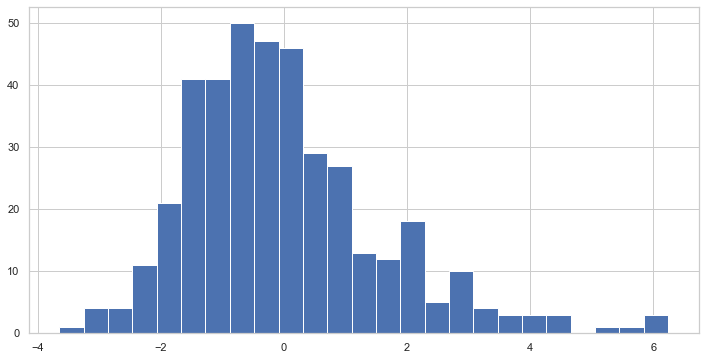

In [133]:
trainL[1][0].hist(bins=25)

<AxesSubplot:>

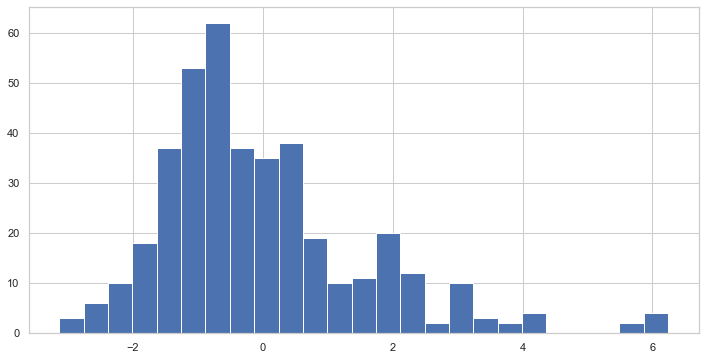

In [134]:
train_augL[1][0].hist(bins=25)

The distributions look almost identical 

### Augmented Data Evaluation

In [135]:
train_all=[]
for count in range (len(trainL)):
    train_all.append(pd.concat([trainL[count], train_augL[count]]))

print('Original train data shape: {}'.format(trainL[0].shape))
print('Augmented train data shape: {}'.format(train_all[0].shape))

Original train data shape: (398, 41)
Augmented train data shape: (796, 41)


In [169]:
y_pred=train_all[0]['Morbidité'].copy()
X_aug=[]
for i in range (len(trainL)):
    X_aug.append(train_all[i].copy())
    del X_aug[i]['Morbidité']

In [170]:
y_pred.shape

(796,)

### Cross validation

Many a times, the data is imbalanced, i.e there may be a high number of class1 instances but less number of other class instances. Thus we should train and test our algorithm on each and every instance of the dataset. Then we can take an average of all the noted accuracies over the dataset

##### On the augmented training data

In [138]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    if model == models[0]:
            cv_result = cross_val_score(model,X_aug[4],y_pred, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[1]:
            cv_result = cross_val_score(model,X_aug[5],y_pred, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[2]:
            cv_result = cross_val_score(model,X_aug[1],y_pred, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[3]:
            cv_result = cross_val_score(model,X_aug[6],y_pred, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[4]:
            cv_result = cross_val_score(model,X_aug[2],y_pred, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[5]:
            cv_result = cross_val_score(model,X_aug[0],y_pred, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[6]:
            cv_result = cross_val_score(model,X_aug[3],y_pred, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2


,CV Mean,Std
Linear Svm,0.565285,0.049399
Radial Svm,0.576377,0.085214
Logistic Regression,0.514873,0.072062
KNN,0.543861,0.078791
Decision Tree,0.610237,0.097989
Naive Bayes,0.553877,0.152338
Random Forest,0.744415,0.130303


##### On the initial training data

In [139]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    if model == models[0]:
            cv_result = cross_val_score(model,X_train_sL[4],y_train_s, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[1]:
            cv_result = cross_val_score(model,X_train_sL[5],y_train_s, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[2]:
            cv_result = cross_val_score(model,X_train_sL[1],y_train_s, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[3]:
            cv_result = cross_val_score(model,X_train_sL[6],y_train_s, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[4]:
            cv_result = cross_val_score(model,X_train_sL[2],y_train_s, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[5]:
            cv_result = cross_val_score(model,X_train_sL[0],y_train_s, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
    if model == models[6]:
            cv_result = cross_val_score(model,X_train_sL[3],y_train_s, cv = kfold,scoring = "accuracy")
            cv_result=cv_result
            xyz.append(cv_result.mean())
            std.append(cv_result.std())
            accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2


,CV Mean,Std
Linear Svm,0.585449,0.046063
Radial Svm,0.673590,0.100251
Logistic Regression,0.575192,0.051044
KNN,0.540962,0.146081
Decision Tree,0.706603,0.102096
Naive Bayes,0.594167,0.188648
Random Forest,0.869487,0.046923


<AxesSubplot:>

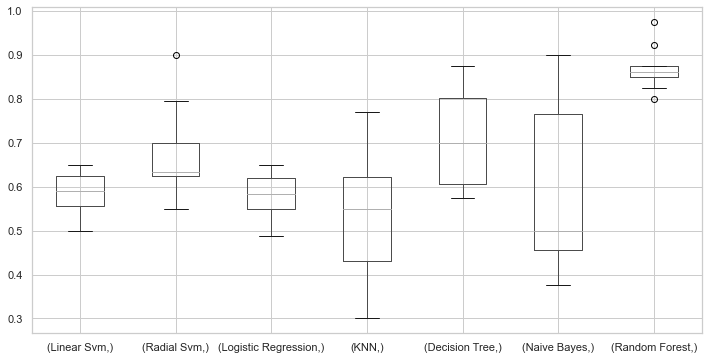

In [140]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

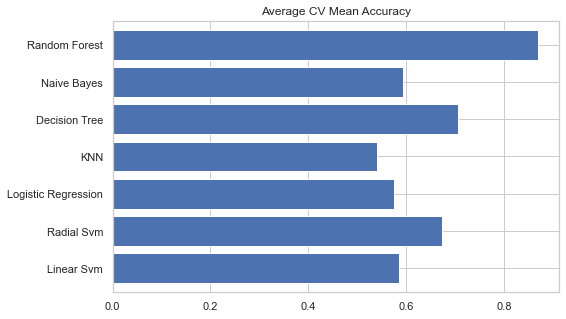

In [141]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

The classification accuracy can be sometimes misleading due to imbalance. We can get a summarized result with the help of confusion matrix, which shows where did the model go wrong, or which class did the model predict wrong

### Confusion Matrix

##### On the augmented data

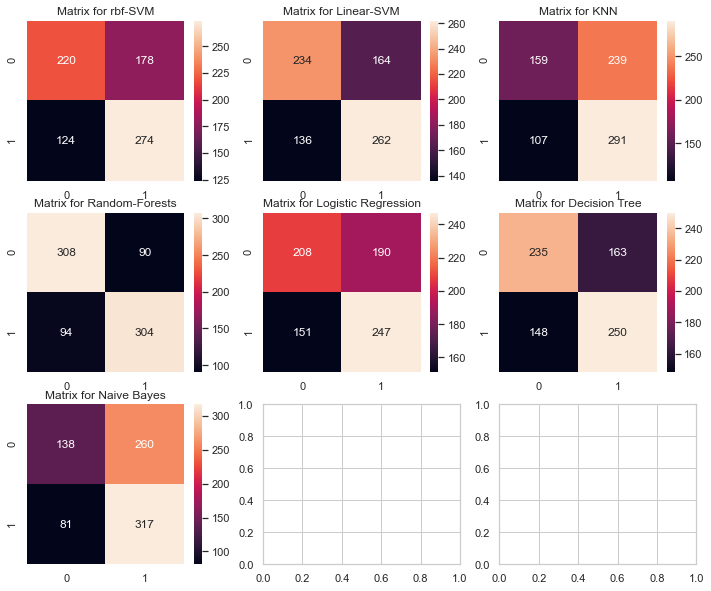

In [142]:
#It gives the number of correct and incorrect classifications made by the classifier.
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred1 = cross_val_predict(svm.SVC(kernel='rbf'),X_aug[5],y_pred,cv=10)
sns.heatmap(confusion_matrix(y_pred,y_pred1),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred1 = cross_val_predict(svm.SVC(kernel='linear'),X_aug[4],y_pred,cv=10)
sns.heatmap(confusion_matrix(y_pred,y_pred1),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred1 = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X_aug[6],y_pred,cv=10)
sns.heatmap(confusion_matrix(y_pred,y_pred1),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred1 = cross_val_predict(RandomForestClassifier(n_estimators=100),X_aug[3],y_pred,cv=10)
sns.heatmap(confusion_matrix(y_pred,y_pred1),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred1 = cross_val_predict(LogisticRegression(),X_aug[1],y_pred,cv=10)
sns.heatmap(confusion_matrix(y_pred,y_pred1),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred1 = cross_val_predict(DecisionTreeClassifier(),X_aug[2],y_pred,cv=10)
sns.heatmap(confusion_matrix(y_pred,y_pred1),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred1 = cross_val_predict(GaussianNB(),X_aug[0],y_pred,cv=10)
sns.heatmap(confusion_matrix(y_pred,y_pred1),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

##### on the initial balanced data

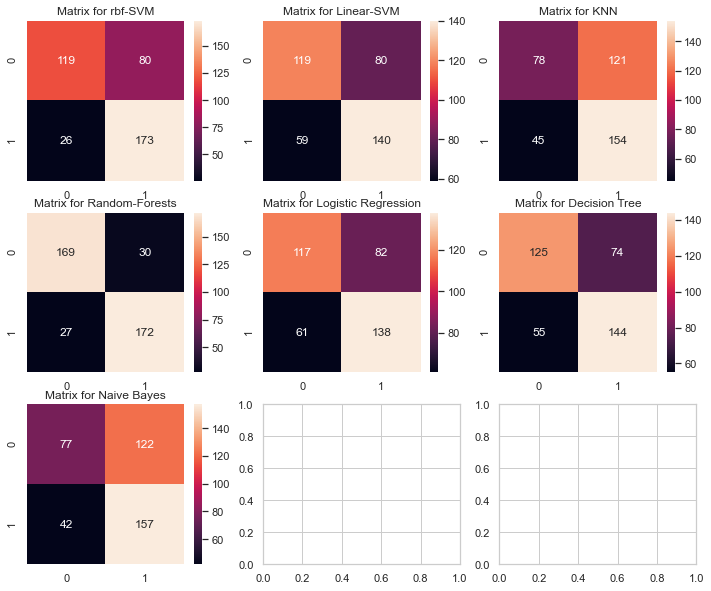

In [143]:
#It gives the number of correct and incorrect classifications made by the classifier.
f,ax=plt.subplots(3,3,figsize=(12,10))
y_train_s1 = cross_val_predict(svm.SVC(kernel='rbf'),X_train_sL[5],y_train_s,cv=10)
sns.heatmap(confusion_matrix(y_train_s,y_train_s1),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_train_s1 = cross_val_predict(svm.SVC(kernel='linear'),X_train_sL[4],y_train_s,cv=10)
sns.heatmap(confusion_matrix(y_train_s,y_train_s1),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_train_s1 = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X_train_sL[6],y_train_s,cv=10)
sns.heatmap(confusion_matrix(y_train_s,y_train_s1),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_train_s1 = cross_val_predict(RandomForestClassifier(n_estimators=100),X_train_sL[3],y_train_s,cv=10)
sns.heatmap(confusion_matrix(y_train_s,y_train_s1),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_train_s1 = cross_val_predict(LogisticRegression(),X_train_sL[1],y_train_s,cv=10)
sns.heatmap(confusion_matrix(y_train_s,y_train_s1),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_train_s1 = cross_val_predict(DecisionTreeClassifier(),X_train_sL[2],y_train_s,cv=10)
sns.heatmap(confusion_matrix(y_train_s,y_train_s1),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_train_s1 = cross_val_predict(GaussianNB(),X_train_sL[0],y_train_s,cv=10)
sns.heatmap(confusion_matrix(y_train_s,y_train_s1),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

Interpreting Confusion Matrix

The left diagonal shows the number of correct predictions made for each class while the right diagonal shows the number of wrong prredictions made. Lets consider the plot for KNN:

1)The no. of correct predictions are 78(for not having complications) + 154(for having complication) with the mean CV accuracy being (78+154)/398 = 58% which we did get earlier.

2)Errors--> Wrongly Classified 45 people having complications as not having complications and 121 patients not having complications as having complications. Thus it has made more mistakes by predicting people not having complications as having complications.

By looking at all the matrices, we can say that Random forest has a higher chance in correctly predicting those who didn't have complications and those who did have issues during the operation.

### Hyper parameter tunning

The machine learning models are like a Black-Box. There are some default parameter values for this Black-Box, which we can tune or change to get a better model. Like the C and gamma in the SVM model and similarly different parameters for different classifiers, are called the hyper-parameters, which we can tune to change the learning rate of the algorithm and get a better model. This is known as Hyper-Parameter Tuning.

We will tune the hyper-parameters for the best classifier randomForest.

##### Random Forest

In [144]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train_sL[3],y_train_s)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8746794871794872

Commentaire: After tuning random forest's parameters, the score has become 87.45%.

In [145]:
RFC_best

RandomForestClassifier(bootstrap=False, max_features=3)

In [146]:
from sklearn.metrics import classification_report

In [147]:
print(classification_report(y_Test, RFC_best.predict(X_TestL[3])))

              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83        47
         1.0       0.67      0.19      0.30        21

    accuracy                           0.72        68
   macro avg       0.70      0.57      0.56        68
weighted avg       0.71      0.72      0.66        68



#### Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

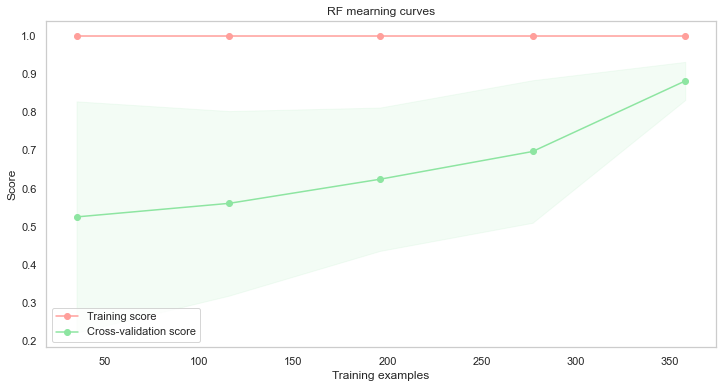

In [148]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train_sL[3],y_train_s,cv=kfold)

Interpretation : The Random Forest algorithm does overfit. Meanwhile, Cross-Validation is a good, but not perfect, technique to minimize over-fitting.  According to the growing cross-validation curves random forest could perform better with more training examples.

 ##### Feature importance of random forest classifier

In order to see the most informative features for the prediction of our target, i displayed the feature importance for the random forest classifier.

1.0


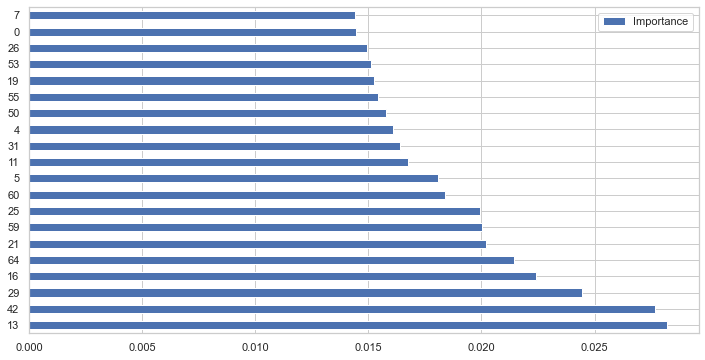

In [149]:
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
       model.feature_importances_  , 
      columns = [ 'Importance' ] , 
      index = X.columns 
   )
    imp = imp.sort_values( [ 'Importance' ] , ascending = False )
    imp[ : 20].plot( kind = 'barh' )
    print (model.score( X , y ))

plot_model_var_imp(RFC_best, X_train_sL[3],y_train_s)

### Making predictions

In [166]:
RFC = RandomForestClassifier(bootstrap=False, max_features=3, n_estimators=300)
RFC.fit(X_train_sL[3],y_train_s)
y_pred1 = RFC.predict(X_TestL[3])

In [167]:
df=pd.DataFrame({'Actual':y_Test, 'Predicted':y_pred1})
df.head(50)

,Actual,Predicted
102,1.0,0.0
125,0.0,0.0
11,0.0,0.0
248,0.0,1.0
238,0.0,0.0
334,0.0,0.0
112,1.0,0.0
147,0.0,0.0
89,1.0,0.0
173,0.0,0.0


In [162]:
df1=df.reset_index(drop=True)
count_true=0
count_false=0
for i in range (df1.shape[0]):
    if df1['Actual'][i]==df1['Predicted'][i]:
        count_true+=1
    else:
        count_false+=1
        
print("Nombre de lignes ayant une prediction correcte est:",count_true)
print("Nombre de lignes ayant une fausse prediction est:",count_false)

Nombre de lignes ayant une prediction correcte est: 51
Nombre de lignes ayant une fausse prediction est: 17
